In [1]:
#!pip install rdrand

## loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
traces = np.load('traces_NTRU.npy')

In [3]:
traces.shape

(4, 100, 12000)

In [4]:
!ls cycle*

cycleIndexes.npy
cycleIndexes5000.npy


In [5]:
cycleIndexes = np.load('cycleIndexes.npy')

In [6]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa
project = cw.open_project("project_NTRU.cwp")
#attack = cwa.cpa(proj)

In [7]:
N=31
p=8
m=7

### Playing with CW project
Even though we do not really use the CW project later...

In [8]:
project.get_filename()

'C:\\Users\\tomas\\ChipWhisperer5_64\\cw\\home\\portable\\chipwhisperer\\jupyter\\01_NTRU - kopie - dobre vysledky\\project_NTRU.cwp'

In [9]:
print("one input (bytes):")
print(project.textins[0])
print(type(project.textins[0]))

print("\none key (bytes):")
print(project.keys[0])
print("one key (uint16):")
print(np.frombuffer(project.keys[0],dtype="uint16"))
print(type(project.keys[0]))

print("\none output (bytes):")
print(project.textouts[0])
print(type(project.textouts[0]))

one input (bytes):
[  0   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0
 255   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0
 255   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0 255   0
 255   0 255   0 255   0 255   0  67  62]
<class 'numpy.ndarray'>

one key (bytes):
[ 1  0  4  0  5  0  7  0  9  0 11  0 13  0 14  0  0  0  2  0  6  0  8  0
 12  0 15  0 17  0]
one key (uint16):
[ 1  4  5  7  9 11 13 14  0  2  6  8 12 15 17]
<class 'numpy.ndarray'>

one output (bytes):
[126   0   0   0 126   0 127   0   0   0   0   0 126   0   0   0 126   0
   0   0 127   0   0   0 126   0   0   0   0   0 126   0 127   0 126   0
 127   0 127   0 127   0 127   0 127   0 127   0 127   0 127   0 127   0
 127   0 127   0 127   0 127   0]
<class 'numpy.ndarray'>


In [10]:
print("All the keys used (original order, uint16)")
new_values=np.unique(project.keys,axis=0,return_index=True)[1]
print(new_values)
newBlist = []
for indexTmp in sorted(new_values):
    newBlist.append(np.frombuffer(project.keys[int(indexTmp)],dtype="uint16"))
newBlist=np.array(newBlist)
print(newBlist)

print("\nAll the inputs used (sorted, uint16):")
inputCW=np.array([np.frombuffer(row,dtype="uint16") for row in np.unique(project.textins,axis=0)])
print(inputCW)

print("\nAll the outputs used (sorted, uint16):")
outputCW=np.array([np.frombuffer(row,dtype="uint16") for row in np.unique(project.textouts,axis=0)])
print(outputCW)

All the keys used (original order, uint16)
[10 20  0 30]
[[ 1  4  5  7  9 11 13 14  0  2  6  8 12 15 17]
 [ 0  3  4  5  7  9 10 13  2  6  8 12 15 16 18]
 [ 0  3  6  9 11 13 16 19  2  5  7  8 10 12 14]
 [ 1  4  7  8 10 12 15 17  0  3  6  9 11 13 16]]

All the inputs used (sorted, uint16):
[[    0   255   255 ...   255   255 49686]
 [    0   255   255 ...   255   255 36632]
 [    0   255   255 ...   255   255  1057]
 ...
 [    0   255   255 ...   255   255 57063]
 [    0   255   255 ...   255   255 27882]
 [    0   255   255 ...   255   255 33791]]

All the outputs used (sorted, uint16):
[[  0 127 126   0   0   0 126   0 126   0   0 127 126   0 127 126 126 127
  126 127 127 127 127 127 127 127 127 127 127 127 127]
 [  0 127 126   0 127 126   0 126 126   0 126   0 126   0 126 127   0 127
  127   0 127 127 127 127 127 127 127 127 127 127 127]
 [126   0 126 127   0   0 126   0 126   0 127   0 126   0   0 126 127 126
  127 127 127 127 127 127 127 127 127 127 127 127 127]
 [126   0 127 126   

In [11]:
print("Traces:")
print(type(project.waves))
print(type(project.waves[0]))
print(np.array(project.waves[0]))
waves=np.array(project.waves)
print(waves.shape)
waves=np.array(np.split(waves,len(newBlist)))
print(waves.shape)

Traces:
<class 'chipwhisperer.common.api.ProjectFormat.IndividualIterable'>
<class 'numpy.memmap'>
[-0.09765625  0.17578125  0.02734375 ...  0.18359375  0.01171875
 -0.2890625 ]
(40, 12000)
(4, 10, 12000)


## Let us start with the attack

We use two methods:
1) finding the minimum of peaks  
2) finding the best rotation by computing least squares.

In [12]:
def FindTheKey(trace,clock_cycles,m,dtype=list):
    # main function for method 1 - finding the minimum
    EstimatedNegativeKeyArray=[]
    for listCycles in clock_cycles[:m]:
        EstimatedNegativeKeyArray.append(np.argsort(trace[listCycles])[0])
        #another possibility
        #EstimatedNegativeKeyArray.append(np.argmin(trace[listCycles]))
        #for testing
        #print("trace[listCycles]",trace[listCycles])
        #print("np.argmin(trace[listCycles])",np.argmin(trace[listCycles]))
    
    EstimatedPositiveKeyArray=[]
    for listCycles in clock_cycles[m:]:
        EstimatedPositiveKeyArray.append(np.argsort(trace[listCycles])[0])
        # another possibility
        #EstimatedPositiveKeyArray.append(np.argmin(trace[listCycles]))
        #for testing
        #print("trace[listCycles]",trace[listCycles]) a
        #print("np.argmin(trace[listCycles])",np.argmin(trace[listCycles]))
    
    EstimatedKeyArray=EstimatedPositiveKeyArray+EstimatedNegativeKeyArray
    if dtype==list:
        return EstimatedKeyArray
    if dtype==np.ndarray:
        return np.array(EstimatedKeyArray)

def CompareLists(list1,list2, dtype=list):
    # this function is comparing coefficients of two lists. It returns an array of the same size.
    # For every equal element it returns 0 and for every non-equal element it returns 1.
    boolList=[]
    for i in range(len(list1)):
        if list1[i]==list2[i]:
            boolList.append(0)
        else:
            boolList.append(1)
    if dtype==list:
        return boolList
    if dtype==np.ndarray:
        return np.array(boolList)

def FindKeyOrder(theTrueKey,trace,clock_cycles,m, dtype=list):
    # follows guessing key entropy concept
    NegativeKeyOrder=[]
    i=m+1
    printBool=1 # for testing
    for listCycles in clock_cycles[:m]:
        a = np.argsort(trace[listCycles])[::]
        order = np.where(a == theTrueKey[i])[0]
        NegativeKeyOrder.append(order[0])
        if False: #for testing
            print("a=",a)
            print("theEstimatedKey[i]=", theTrueKey[i])
            print("order=",order)
            print("order[0]=",order[0])
        i=i+1
        printBool=printBool+1 # for testing

    i=i%len(theTrueKey)
    PositiveKeyOrder=[]
    for listCycles in clock_cycles[m:]:
        a = np.argsort(trace[listCycles])[::]
        order = np.where(a == theTrueKey[i])[0]
        PositiveKeyOrder.append(order[0])
        if False: #for testing
            print("a=",a)
            print("theEstimatedKey[i]=", theTrueKey[i])
            print("order=",order)
            print("order[0]=",order[0])
        i=i+1
        printBool=1+printBool #for testing
        
    KeyOrder=PositiveKeyOrder+NegativeKeyOrder
    if dtype==list:
        return KeyOrder
    if dtype==np.ndarray:
        return np.array(KeyOrder)

def LeastSquares(list1,list2):
    # function realizes the least square method
    sum=0
    for i in range(len(list1)):
        sum+=(list1[i]-list2[i])**2
    return np.sqrt(sum)

def FindKeyDifferences(trace,clock_cycles,m,N, dtype=list):
    # main function for method 2 - rotating and looking for the best match by least square method.
    keyDifferences=[]
    for index in range(1,len(clock_cycles) ):
        pattern = trace[clock_cycles[index-1]]
        target = trace[clock_cycles[index]]
        import sys
        min=sys.maxsize
        ValList=[]
        for i in range(0,N):
            Val = LeastSquares(pattern,np.roll(target,i))
            ValList.append(Val)
            if (Val<min):
                out=N-i
                min = Val
        keyDifferences.append(out)
    if dtype==list:
        return keyDifferences
    if dtype==np.ndarray:
        return np.array(keyDifferences)

def TrueKeyDifferences(b,p,N, dtype=list):
    if type(b)==np.ndarray:
        return np.concatenate(( b[p+1:]-np.roll(b,1)[p+1:], [(int(b[0])-b[-1])%N], b[1:p]-np.roll(b,1)[1:p] ))
    # auxiliary function for method 2
    keyDifferTmp=[]
    for i in range(p+1,len(b)):
        keyDifferTmp.append( b[i]-b[i-1] )
    keyDifferTmp.append( (int(b[0])-b[-1])%N )
    for i in range(1,p):
        keyDifferTmp.append( b[i]-b[i-1] )
    if dtype==list:
        return keyDifferTmp
    if dtype==np.ndarray:
        return np.array(keyDifferTmp)

def ReverseBlist(blist,p):
    # works for numpy ndarray as well as python lists
    if type(blist)==np.ndarray:
        return np.concatenate((blist[:,p:],blist[:,:p]),axis=1)
    else:
        reversedBlist=[]
        for i in range(len(blist)):
            first = blist[i][:p]
            second= blist[i][p:]
            reversedBlist.append(second+first)

        return reversedBlist

def ReverseB(b,p):
    revB=np.zeros(p+p-1,dtype=np.dtype("uint16"))
    revB[p-1:] = b[:p]
    revB[:p-1] = b[p:]
    return revB

# some testing:
# of function TrueKeyDifferences
b=[1,4,5,7,9,11,13,14,0,2,6,8,12,15,17]
assert(TrueKeyDifferences(b,p,N)==[2,4,2,4,3,2,15,3,1,2,2,2,2,1])
b=np.array([1,4,5,7,9,11,13,14,0,2,6,8,12,15,17])
assert(np.array_equal(TrueKeyDifferences(b,p,N),[2,4,2,4,3,2,15,3,1,2,2,2,2,1]) )
b=[0, 3, 4, 5, 7, 9, 10, 13, 2, 6, 8, 12, 15, 16, 18]
assert(TrueKeyDifferences(b,p,N)==[4,2,4,3,1,2,13,3,1,1,2,2,1,3])

# of function CompareLists
list1=[0,0,1,2,3,0,0] 
list2=[0,0,1,2,0,1,1]
list3=[1,1,5,5,5,0,0]
assert(CompareLists(list1,list2)==[0,0,0,0,1,1,1])
assert(CompareLists(list1,list3)==[1,1,1,1,1,0,0])

# of FindTheKey
import sys
traceTmp0=np.array(project.waves[0])
traceTmp0123=np.array(project.waves[1])
for i,cycle in enumerate(cycleIndexes):
    # we force the minimum possible value on convenient possitions:
    traceTmp0[cycle[0]] = -sys.maxsize  # on possition 0
    traceTmp0123[cycle[i]] = -sys.maxsize  # on possitions 0,1,2,3, and so on
assert(FindTheKey(traceTmp0,cycleIndexes,m)==[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
assert(FindTheKey(traceTmp0123,cycleIndexes,m)==[7,8,9,10,11,12,13,14,0,1,2,3,4,5,6])
print("some of these functions work fine :)")

some of these functions work fine :)


In [13]:
def FullAttackAnalysis(b,traces,num_of_traces_used,clock_cycles,N,p,m,firstMethod=True,secondMethod=True, PairOutput=False):
    # we assume we have traces already imported
    # we assume we know exact clock cycles we attack

    # returns two numbers describing how many mistakes we did with each method

    # compute mean of traces
    mean_trace=np.mean(traces[:num_of_traces_used],axis=0)
    
    # method with argmin
    if firstMethod:
        EstimatedKey = FindTheKey(mean_trace,clock_cycles,m)
        boolList = CompareLists(b,EstimatedKey,np.ndarray)
        method1=sum(boolList)
        if PairOutput:
            method1=(sum(boolList[0:p]),sum(boolList[p:N]))

    # method with least square and rotations
    if secondMethod:
        keyDifferences = FindKeyDifferences(mean_trace,clock_cycles,m,N)
        trueKeyDiff = TrueKeyDifferences( b,p,N )
        boolList = CompareLists(trueKeyDiff,keyDifferences,np.ndarray)
        method2=sum(boolList)
        if PairOutput:
            method2=(sum(boolList[0:m]),sum(boolList[m:N]))
        
    if firstMethod and secondMethod:
        return method1, method2
    elif firstMethod and not(secondMethod):
        return method1
    else:
        return method2

TODO: it would be usefull to have continous method to compute:  
"mean_trace=np.mean(traces[:num_of_traces_used],axis=0)"

In [14]:
def GetCycleIndexes(Out1, Out2, In1, In2, firstParameter=1106,secondParameter=4926):
    downPoints=[]
    N=31
    m=7
    p=8
    firstAdditionsInCycles=[]

    # the first half corresponding to minus key values
    firstAdditionsInCycles=np.array(range(m))*Out1 + firstParameter
    for tmp in firstAdditionsInCycles:
        downPoints.append(np.array(range(N))*In1 + tmp)

    # the second half corresponding to plus key values
    firstAdditionsInCycles=np.array(range(p))*Out2 + secondParameter
    for tmp in firstAdditionsInCycles:
        downPoints.append(np.array(range(N))*In2 + tmp)

    return np.array(downPoints)

# Attack

### Analyzing sensitivity of the two methods based on number of traces used

In [15]:
!ls *0FFF*cwp
print()
!ls *one*cwp
print()
!ls cycle*

project_NTRU_random_keys_1000_0FFF.cwp
project_NTRU_random_keys_100_0FFF.cwp
project_NTRU_random_keys_5000_0FFF.cwp

project_NTRU_random_keys_2000_one_random_ciphertext.cwp
project_NTRU_random_keys_50_one_random_ciphertext.cwp

cycleIndexes.npy
cycleIndexes5000.npy


In [20]:
import chipwhisperer as cw
# CHOOSE this!
project = cw.open_project("project_NTRU_random_keys_5000_0FFF.cwp")

# CHOOSE this!
cycleIndexes = np.load('cycleIndexes.npy')
#cycleIndexes = GetCycleIndexes(Out1=486,Out2=552,In1=15,In2=17,firstParameter=1106,secondParameter=4926)

print("All the keys used (original order, uint16)")
new_values=np.unique(project.keys,axis=0,return_index=True)[1]
blist = []
for indexTmp in sorted(new_values):
    blist.append(np.frombuffer(project.keys[int(indexTmp)],dtype="uint16"))
blist=np.array(blist)
print(blist)
print("number of keys is",len(blist),"\n")

print("All the ciphertexts used (original order, uint16)")
new_values=np.unique(project.textins,axis=0,return_index=True)[1]
CTlist = []
for indexTmp in sorted(new_values):
    CTlist.append(np.frombuffer(project.textins[int(indexTmp)],dtype="uint16"))
CTlist=np.array(CTlist)
print(CTlist)
print("number of ciphertexts is",len(CTlist),"\n")

numberOfTraces=(len(project.waves)//len(blist))
print("number of traces is:",numberOfTraces)

traces=np.array(project.waves)
traces=np.array(np.split(traces,len(blist)))

print("traces.shape:",traces.shape)

All the keys used (original order, uint16)
[[ 3 12 13 ... 19 20 30]
 [ 0  4  5 ... 21 22 29]
 [ 0  1  6 ... 17 22 29]
 ...
 [ 6 10 12 ... 20 23 28]
 [12 15 18 ... 22 24 27]
 [ 2  7 10 ... 15 17 29]]
number of keys is 5000 

All the ciphertexts used (original order, uint16)
[[    0   255   255 ...   255   255 40233]
 [    0   255   255 ...   255   255 21845]
 [    0   255   255 ...   255   255 31224]
 ...
 [    0   255   255 ...   255   255 14447]
 [    0   255   255 ...   255   255 38575]
 [    0   255   255 ...   255   255  3840]]
number of ciphertexts is 34947 

number of traces is: 10
traces.shape: (5000, 10, 12000)


In [21]:
inputCW=np.array([np.frombuffer(row,dtype="uint16") for row in np.unique(project.textins,axis=0)])

print("\n'number of traces' - (# mistakes by method 1, # mistakes by method 2)\n")
MAX=10 #len(blist)
for i in range(MAX):  #len(blist)
    print("  ----  Analysis of results with \nkey:",blist[i],"\ninput:\n",inputCW)
    for numTraces in range(1,numberOfTraces,3):
        print(numTraces,"-", FullAttackAnalysis(blist[i],traces[i],numTraces,cycleIndexes,N,p,m) )
    print()
if MAX!=len(blist):
    print("They are not all printed out...")
    print("If you want more, change value of 'MAX' :)")
    


'number of traces' - (# mistakes by method 1, # mistakes by method 2)

  ----  Analysis of results with 
key: [ 3 12 13 14 16 22 24 25  1  6 10 17 19 20 30] 
input:
 [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
1 - (0, 1)
4 - (0, 0)
7 - (0, 0)

  ----  Analysis of results with 
key: [ 0  4  5  7 10 13 17 20  2 11 14 15 21 22 29] 
input:
 [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
1 - (0, 1)
4 - (0, 0)
7 - (0, 0)

  ----  Analysis of results with 
key: [ 0  1  6  9 11 19 21 23  2  3  8 15 17 22 29] 
input:
 [[    0   255   255 ...   255   255   256]
 [  

### Looking more deeply on one of the two methods

In [22]:
firstMethodBool=True
secondMethodBool=False

from tqdm.notebook import tnrange
import pandas as pd
pandasColumns=[f"b{i}" for i in range(1,len(blist)+1)]
pandasData=np.zeros((numberOfTraces,len(blist)),dtype="int")

#pandasData=np.load("pandasData100x10traces.npz")["pandasData"]
for i in tnrange(len(blist), desc='Analyzing'):
    for numTraces in range(1,numberOfTraces+1):
        out=FullAttackAnalysis(blist[i],traces[i],numTraces,cycleIndexes,N,p,m,
                                                     firstMethodBool,secondMethodBool,PairOutput=True)
        pandasData[numTraces-1,i]=out[0]+out[1]
        
df = pd.DataFrame(pandasData,index=np.arange(1,numberOfTraces+1),columns=pandasColumns)

Analyzing:   0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
# if it took too long, save it :-)

#np.savez_compressed("pandasData100x10traces",pandasData=pandasData)

In [24]:
if firstMethodBool:
    print("You are analyzing the first method:")
if secondMethodBool:
    print("You are analyzing the second method:")

# numberOfTraces
df.head(10).style.background_gradient().set_caption("number of mistakes for number of used traces")

You are analyzing the first method:


In [25]:
def RowVisualization(index):
    index=index-1
    row = pandasData[index]

    columnsProb=np.unique(row)
    frequencies=np.zeros(len(columnsProb),dtype="int")
    for i,col in enumerate(columnsProb):
        frequencies[i]=np.count_nonzero(row == col)
    relativeFrequencies=frequencies/len(row)*100
    
    print("Possible values in the row:  ",columnsProb)
    print("mean of values:",np.mean(row))
    print("Its frequencies:           ", frequencies)
    np.set_printoptions(formatter={'float': '{: 0.1f}%'.format})
    print("Its relative frequencies:  ", relativeFrequencies)
    #np.set_printoptions()
    print("Size of data:", row.size )
    
    fig = plt.figure()
    plt.style.use('ggplot')
    plt.bar(columnsProb,frequencies,width=0.8, align="center")
    plt.title("bar chart with frequencies")
    fig.set_figheight(4)
    fig.set_figwidth(4)
    plt.xticks(columnsProb)
    plt.show()
    

In [31]:
from ipywidgets import interact,fixed
import ipywidgets as widgets
print("Choose how many traces are avereged on the slider 'Row' and see how the statistics changes:")
interact(RowVisualization, index= widgets.IntSlider(min=1, max=numberOfTraces, value=1, step=1, description="Row",
                                                    layout=widgets.Layout(width='95%'), continuous_update=False) );

Choose how many traces are avereged on the slider 'Row' and see how the statistics changes:


interactive(children=(IntSlider(value=1, continuous_update=False, description='Row', layout=Layout(width='95%'…

### only for method 1:

In [27]:
from ipywidgets import interact,fixed
import ipywidgets as widgets

#helper printing function for interactive attack on Points
def PrintPoints(points,bRev,estimatedKeyLocalRev):
    size=np.amax(points)-np.amin(points)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(9,5))
    plt.xlabel('x - axis')
    plt.ylabel('y - axis')
    plt.title('Points from the attack')
    
    for i,row in enumerate(points):
        off= 0.3*size*(len(row)-i)
        xs = list(range(len(row)))
        xy = [ off + row[j] for j in range(len(row))]
        plt.plot(xs,[off+np.mean(row)]*len(row), "-k")
        plt.plot(xs,xy, "o")
        tmp=bRev[i]
        tmp2=estimatedKeyLocalRev[i]
        if tmp!=tmp2:
            plt.annotate(tmp,(tmp,xy[tmp]), xytext=(tmp-size,xy[tmp]+0.1*size), fontsize=12, color="red", weight="bold") # #990000
        plt.annotate(tmp2,(tmp2,xy[tmp2]), xytext=(tmp2-size,xy[tmp2]+0.1*size), fontsize=12,color="black", weight="heavy") 
    #plt.legend()
    plt.show()
    
bRevList = ReverseBlist(blist,p)

def InteractAttackPoints(bIndex,numTracesForAttackPoints):
    bIndex=bIndex-1
    bRev=bRevList[bIndex]
    print("the (reversed) key is:",bRev)
    meanTrace = np.mean(traces[bIndex,0:numTracesForAttackPoints],axis=0)
    estimatedKey = FindTheKey(meanTrace,cycleIndexes,m)
    print("the estimated key is:",estimatedKey)
    estimatedKeyRev=ReverseB(estimatedKey,p)
    
    boolList = CompareLists(blist[bIndex],estimatedKey,dtype=np.ndarray)
    print(f"In total there are {sum(boolList)} mistake(s).")
    KeyOrder=FindKeyOrder(blist[bIndex],meanTrace,cycleIndexes,m,dtype=np.ndarray)
    print("Order of each key-value: ",KeyOrder)
    
    pointsFromTrace=[]
    for listCycles in cycleIndexes:
        pointsFromTrace.append(meanTrace[listCycles])
    pointsFromTrace = np.array(pointsFromTrace)
    PrintPoints(pointsFromTrace,bRev,estimatedKeyRev)

%matplotlib notebook

interact(InteractAttackPoints, 
         bIndex= widgets.IntSlider(min=1, max=len(bRevList), value=1, step=1, description="key",layout=widgets.Layout(width='95%'),continuous_update=False),
         numTracesForAttackPoints= widgets.IntSlider(min=1, max=numberOfTraces, value=1, step=1, description="#-traces",layout=widgets.Layout(width='95%'), continuous_update=False) );

interactive(children=(IntSlider(value=1, continuous_update=False, description='key', layout=Layout(width='95%'…

In [28]:
# Choose a value you want:
numTraces=1

meanTraces=np.mean(traces[:,:numTraces],axis=1)
print(meanTraces.shape)

(5000, 12000)


In [29]:
"""
with open("randomfile.txt", "w") as external_file:
    add_text = "This text will be added to the file"
    print(add_text, file=external_file)
    external_file.close()
"""

print("we used np.argmin to find the key values...")
print("number of traces used:", numTraces)
print()
for i in range(len(blist)):
    print("Results for data with" ,"\ninput:",inputCW)
    print("Key                    : ",np.array(blist[i]))
    EstimatedKey = FindTheKey(meanTraces[i],cycleIndexes,7,dtype=np.ndarray)
    print("Estimated key          : ",EstimatedKey)

    
    #print("mistakes are on these positions:")
    boolList = CompareLists(blist[i],EstimatedKey,dtype=np.ndarray)
    print(f"In total there are {sum(boolList)} mistake(s).")
    KeyOrder=FindKeyOrder(blist[i],meanTraces[i],cycleIndexes,m,dtype=np.ndarray)
    print("Order of each key-value: ",KeyOrder)
    
    # the second method is just tooo bad... :D so lets skip it
    """
    keyDifferences = FindKeyDifferences(meanTraces[i],cycleIndexes,m,N)
    print("Estimated diff. are   : ", keyDifferences)
    trueKeyDiff = TrueKeyDifferences( blist[i],p,N )
    print("True key diff. are    : ", trueKeyDiff )
    boolList = CompareLists(trueKeyDiff,keyDifferences)
    print(f"In total there are {sum(boolList)} mistake(s).")
    """
    print("\n--------------------\n")

we used np.argmin to find the key values...
number of traces used: 1

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 3 12 13 14 16 22 24 25  1  6 10 17 19 20 30]
Estimated key          :  [ 3 12 13 14 16 22 24 25  1  6 10 17 19 20 30]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  4  5  7 10 13 17 20  2 11 14 15 21 22 29]
Estimated

Estimated key          :  [ 3  6  7 12 14 22 28 30  1  9 15 19 20 25 29]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 4 10 17 18 24 25 29 30  1  8  9 12 13 19 20]
Estimated key          :  [ 4 10 17 18 24 25 29 30  1  8  9 12 13 19 20]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Order of each key-value:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 1  4  5 14 16 23 24 29  2  8 10 12 19 25 28]
Estimated key          :  [ 1  4  5 14 16 23 24 29  2  8 10 12 19 25 28]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 3  5 14 16 19 22 24 28  4 11 12 13 18 21 29

Estimated key          :  [ 3  8 17 19 22 23 25 29  0  5  9 21 24 26 28]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 4  8 14 17 20 22 23 30  0 11 13 18 19 21 28]
Estimated key          :  [ 4  8  8 17 20 22 23 30  0 11 13 18 19 21 28]
In total there are 1 mistake(s).
Order of each key-value:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 1  3 12 13 14 15 21 22  0  5  6 24 26 28 30]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 2  3  8 13 15 20 21 26  0  5 12 16 18 27 30]
Estimated key          :  [ 2  3  8 13 15 20 21 26  0  5 12 16 18 27 30]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 2 11 12 16 18 20 24 30  1  5  6  9 23 25 29]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 5  6 10 13 16 23 25 30  0  3  7  9 14 15 20]
Estimated key          :  [ 5  6 10 13 16 23 25 30  0  3  7  9 14 15 20]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 4  7 10 14 22 24 29 30  8  9 11 13 17 20 25]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 2  9 12 13 14 16 22 24  1  3  4  5 19 21 25]
Estimated key          :  [ 2  9 12 13 14 16 22 24  1  3  4  5 19 21 25]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 1  7  9 11 13 15 24 26  3  6 10 17 19 25 30]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 2  4  5  7 11 16 20 21  6 12 15 17 23 24 28]
Estimated key          :  [ 2  4  5  7 11 16 20 21  6 12 15 17 23 24 28]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 5  6 11 13 16 19 22 28  0  2  8 17 20 24 25]
Estimated key          :  [ 5  6 11 13 16 19 22 28  0  2  8 17 20 24 25]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  1  2  5  9 16 28 29  7 10 13 17 18 21 26

Estimated key          :  [ 0  4  6  9 11 12 19 22  2 15 16 17 21 24 25]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 1  3  4 11 17 22 29 30  0  9 13 15 16 21 27]
Estimated key          :  [ 1  3  4 11 17 22 29 30  0  9 13 15 16 21 27]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  7 21 22 24 25 28 30  1  2  3  5 12 18 20]
Estimated key          :  [ 0  7 21 22 24 25 28 30  1  2  3  5 12 18 20]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 5  9 13 14 17 21 23 27  1  3  7  8 18 20 29

Estimated key          :  [ 3  5  7 17 19 22 27 28  2  4  8  9 10 15 30]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  7  8 12 18 22 28 30  3 13 14 20 23 25 27]
Estimated key          :  [ 0  7  8 12 18 22 28 30  3 13 14 20 23 25 27]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 6 10 11 14 15 16 25 29  2 17 18 19 23 24 27]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  6  7  9 12 19 21 22  4 11 17 18 24 25 28]
Estimated key          :  [ 0  6  7  9 12 19 21 22  4 11 17 18 24 25 28]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

Estimated key          :  [ 0  6  9 11 12 21 24 28  3 13 14 15 16 18 20]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0   255   255 ...   255   255 65535]]
Key                    :  [ 0  2  4  6  8 13 15 26  1  7  9 12 17 20 23]
Estimated key          :  [ 0  2  4  6  8 13 15 26  1  7  9 12 17 20 23]
In total there are 0 mistake(s).
Order of each key-value:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--------------------

Results for data with 
input: [[    0   255   255 ...   255   255   256]
 [    0   255   255 ...   255   255   512]
 [    0   255   255 ...   255   255   768]
 ...
 [    0   255   255 ...   255   255 63999]
 [    0   255   255 ...   255   255 64511]
 [    0  

# Analysis of protection (randomized ciphertext) by Method 2 
### Data: one trace for each random ciphertext:
random keys and multiple random ciphertexts (one trace for each ciphertext)

In [28]:
!ls *mult*cwp
print()
!ls cycle*

project_NTRU_random_keys_500_mult_random_ciphertexts_100.cwp
project_NTRU_random_keys_50_mult_random_ciphertexts_10.cwp

cycleIndexes.npy
cycleIndexes5000.npy


In [35]:
import chipwhisperer as cw
#CHOOSE this!
project = cw.open_project("project_NTRU_random_keys_50_mult_random_ciphertexts_10.cwp")

#CHOOSE this!
cycleIndexes = np.load('cycleIndexes.npy')
#cycleIndexes = GetCycleIndexes(Out1=486,Out2=552,In1=15,In2=17, firstParameter=1106,secondParameter=4926)


print("All the keys used (original order, uint16)")
new_values=np.unique(project.keys,axis=0,return_index=True)[1]
blist = []
for indexTmp in sorted(new_values):
    blist.append(np.frombuffer(project.keys[int(indexTmp)],dtype="uint16"))
blist=np.array(blist)
print(blist)
print()
print("number of keys is",len(blist))

numberOfTraces=(len(project.waves)//len(blist))
print("number of traces (=ciphertexts) per key is:",numberOfTraces)

traces=np.array(project.waves)
traces=np.array(np.split(traces,len(blist)))

print("traces.shape:",traces.shape)
print("total number of samples:",len(project.waves))

All the keys used (original order, uint16)
[[ 0  2  4 10 23 25 26 27  7  8 12 19 21 22 28]
 [ 1  4 10 12 18 23 24 29  7 11 15 21 22 27 28]
 [ 0 11 12 17 19 21 22 29  3  7 15 16 18 24 30]
 [ 1  4  6 12 13 14 18 26  5  7 15 16 17 19 28]
 [ 0  1  9 14 19 22 24 28  5 16 20 23 26 27 30]
 [ 4  5  7 14 15 18 21 25  0 11 17 19 26 27 28]
 [ 0  1  7  9 11 15 18 27 10 12 13 14 17 21 23]
 [ 0  4  6 10 12 14 15 17  1  8 13 19 23 25 26]
 [ 0  9 12 17 20 23 24 25  1  2  5 14 15 27 28]
 [ 3  5  7 14 15 16 28 30  1  4  6 11 21 26 27]
 [ 3  6  7 12 16 18 20 23  1  8  9 10 11 19 25]
 [ 0  4 10 11 12 24 26 28  2  5  7 18 20 23 30]
 [ 0  5  8 11 12 13 16 23  1  3  6 14 18 25 28]
 [ 9 12 13 21 23 25 27 30  4  5  7  8 10 14 20]
 [ 1  2  6 12 14 15 20 29  5 10 11 16 21 22 23]
 [ 2  9 17 25 27 28 29 30  1  6  7 10 15 24 26]
 [ 2  4 12 16 18 19 22 26  9 11 15 20 21 25 27]
 [ 8  9 10 14 15 20 22 24  0  7 19 21 28 29 30]
 [ 0  3  4  5  7 13 17 28  6  8 10 12 20 29 30]
 [ 2  4  5 15 17 18 25 29  0  7 11 12 20 26 2

In [36]:
firstMethodBool=False
secondMethodBool=True

from tqdm.notebook import tnrange
import pandas as pd
pandasColumns=[f"b{i}" for i in range(1,len(blist)+1)]
pandasIndexes=[f"c{i}" for i in range(1,numberOfTraces+1)]

#pandasDataM2=np.load("pandasData500x100traces.npz")["pandasDataM2"]
pandasDataM2=np.zeros((numberOfTraces,len(blist)),dtype="int")

for i in tnrange(len(blist), desc='Analyzing'):
    for numTraces in range(1,numberOfTraces+1):
        out=FullAttackAnalysis(blist[i],[traces[i,numTraces-1]],1,cycleIndexes,N,p,m,
                                                     firstMethodBool,secondMethodBool,PairOutput=True)
        pandasDataM2[numTraces-1,i]=out[0]+out[1]

dfM2 = pd.DataFrame(pandasDataM2,index=pandasIndexes,columns=pandasColumns)
print("ready to see the analysis? :)")

Analyzing:   0%|          | 0/50 [00:00<?, ?it/s]

ready to see the analysis? :)


In [122]:
#np.savez_compressed("pandasData500x100traces",pandasDataM2=pandasDataM2)

In [37]:
dataSize=pandasDataM2.size

# numberOfTraces
dfM2_styled=dfM2.style.background_gradient().set_caption("number of mistakes when attacking with one trace on random ciphertext")
display(dfM2_styled)
#dfM2_styled.to_html(f'dataTable_Method2_Samples_{dataSize}.html')

print()
columnsProb=np.unique(pandasDataM2)
frequencies=np.zeros(len(columnsProb),dtype="int")
for i,col in enumerate(columnsProb):
    frequencies[i]=np.count_nonzero(pandasDataM2 == col)    
relativeFrequencies=frequencies/dataSize*100


Possible values in the table:   [0 1 2 3 4 6 7]
mean of values: 0.612
Its frequencies:              [332  89  34  36   7   1   1]
Its relative frequencies:     [66.4% 17.8% 6.8% 7.2% 1.4% 0.2% 0.2%]
Total size of data: 500


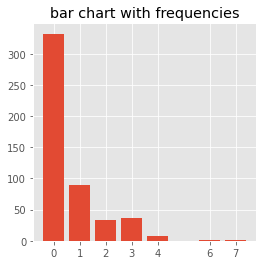

In [38]:
print("Possible values in the table:  ",columnsProb)
print("mean of values:",np.mean(pandasDataM2))
np.set_printoptions(formatter={'float': '{:0.1f}%'.format} )
print("Its frequencies:             ", frequencies)
print("Its relative frequencies:    ", relativeFrequencies)
print("Total size of data:", dataSize )

%matplotlib inline

#printing bar plot
fig = plt.figure()
plt.style.use('ggplot')
plt.bar(columnsProb,frequencies,width=0.8, align="center")
plt.title("bar chart with frequencies")
fig.set_figheight(4)
fig.set_figwidth(4)
plt.xticks(columnsProb)
#plt.savefig(f'BarChart_Method2_Frequencies_Samples_{dataSize}.png')
plt.show()

# Apendix - Interactive Attack on Traces

In [32]:
print(traces.shape)

(5000, 10, 12000)


In [33]:
meanTrace = np.mean(traces[0],axis=0)
print(meanTrace.shape)
print(meanTrace)

(12000,)
[ 0.1%  0.2%  0.0% ...  0.2%  0.0% -0.3%]


In [34]:
%matplotlib notebook

# this needs to be compliant with the beginning
bRev=ReverseB(blist[0],8)
e="[0]+[255]*30"
    
parts=["first","second"]

def InteractAttackTraces(firstParameter, secondParameter, part):
    print()
    Out1=486
    Out2=552
    In1=15
    In2=17

    downPoints=[]
    N=31
    m=7
    p=8
    firstAdditionsInCycles=[]

    # the first half corresponding to minus key values
    if part == "first":
        firstAdditionsInCycles=np.array(range(m))*Out1 + firstParameter
        for firstAddition in firstAdditionsInCycles:
            downPoints.append(np.array(range(N))*In1 + firstAddition)

    # the second half corresponding to plus key values
    if part == "second":
        firstAdditionsInCycles=np.array(range(p))*Out2 + secondParameter
        for firstAddition in firstAdditionsInCycles:
            downPoints.append(np.array(range(N))*In2 + firstAddition)

    array_clock_cycles=np.array(downPoints)

    fig=plt.figure()
    fig.set_figheight(4)
    fig.set_figwidth(9)
    plt.xlabel("clock cycle number")
    plt.ylabel("sample value")
    
    plt.plot(meanTrace, color="orange", label=str(b)+e) 
    plt.style.use('classic')
    
    for j,list in enumerate(array_clock_cycles):
        if part=="second": j+=m
        plt.plot(list,meanTrace[list], "o", color="black", markerfacecolor="None")
        for k,clock in enumerate(list):
            if (k==bRev[j]):
                plt.annotate(k,(clock,meanTrace[clock]), xytext=(clock,meanTrace[clock]), weight="heavy",color='#990000', fontsize=14)
            else:
                plt.annotate(k,(clock,meanTrace[clock]), xytext=(clock,meanTrace[clock]))
        
    if part == "first":
        plt.title("First Cycles")
        plt.xlim([1580,2065])
        plt.ylim([-0.3,0.3])
        plt.show()
        #plt.savefig(f"Average trace of polynomial multiplication - mean {100} - CWNano.png")
        return firstParameter

    else: 
        plt.title("Second Cycles")
        plt.xlim([4900,5455])
        plt.ylim([-0.3,0.3])
        plt.show()
        #plt.savefig(f"Average trace of polynomial multiplication - mean {100} - CWNano.png")
        return secondParameter

In [37]:
from ipywidgets import interact,fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt

interact(InteractAttackTraces, part=fixed("first"), secondParameter= fixed(4926), firstParameter= widgets.IntSlider(min=1104-20, 
                max=1104+20, value=1106, step=1, description="First Parameter",layout=widgets.Layout(width='70%'), continuous_update=False) );


interactive(children=(IntSlider(value=1106, continuous_update=False, description='First Parameter', layout=Lay…

In [36]:
interact(InteractAttackTraces, part=fixed("second"), firstParameter= fixed(1107), secondParameter= widgets.IntSlider(min=4924-20,
                    max=4924+20, value=4926, step=1, description="Second Parameter",layout=widgets.Layout(width='70%'), continuous_update=False));


interactive(children=(IntSlider(value=4926, continuous_update=False, description='Second Parameter', layout=La…